# Extracting wake and filtering it out of data

Restarting from the downsampled xrarray, extraction of active (without SWR) and quiet wake (with SWR) periods and removing these periods from the recordings.

## Load EMG and packages

In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path

%matplotlib widget

# mmap activated to not store everything in memory
folder_base = Path('/Users/ahay/Documents/DATA/NPX/NPX3/reuniens/')
filename = folder_base/ f'RawDataChannelExtractedDS.npy'
all = np.load(filename, mmap_mode= 'r')
all = all.T
EMG = all[:,6]
all.shape

/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_53914/1820584638.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


(6849690, 32)

## High pass filter

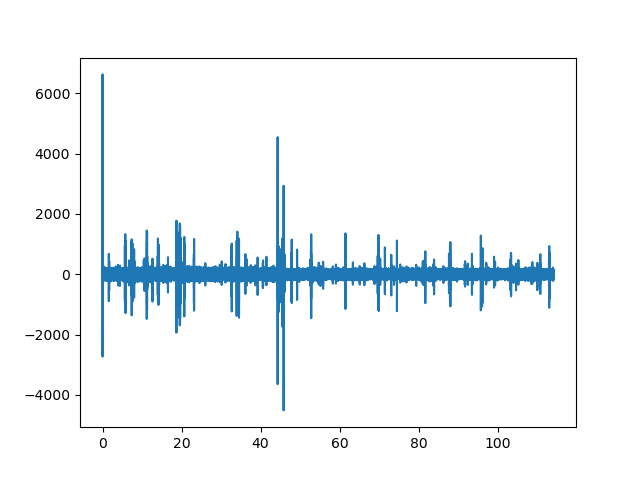

In [2]:
# Filter parameter :
f_lowcut = 200.
f_hicut = 400.
N = 4
fs = 1000
nyq = 0.5 * fs
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction


# Filter creation :
b, a = signal.butter(N, Wn, 'band')
filt_EMG = signal.filtfilt(b, a, EMG)

# Plot
times = np.arange(0, EMG.size/fs, 1./fs)
timesmin = np.arange(0, EMG.size/fs/60, 1./fs/60)

fig, ax = plt.subplots()
ax.plot(timesmin, filt_EMG)


## Continuous Wavelet Transform and projection calculation

In [3]:
# Parameter and computation of CWT
w = 4.
freq = np.linspace(200, 400, 50)
widths = w*fs / (2*freq*np.pi)
EMGcwt = signal.cwt(EMG, signal.morlet2, widths, w=w)

# Projection calculation
absEMGcwt = np.absolute(EMGcwt)
proj_EMGcwt = np.sum(absEMGcwt, axis = 0)/50
mproj_EMGcwt = np.mean(proj_EMGcwt)
sdproj_EMGcwt = np.std(proj_EMGcwt)
sd3proj_EMGcwt = mproj_EMGcwt + sdproj_EMGcwt*3.5
sd05proj_EMGcwt = mproj_EMGcwt + sdproj_EMGcwt*2
sd1proj_EMGcwt = mproj_EMGcwt + sdproj_EMGcwt



/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_53914/1301355207.py:5: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  EMGcwt = signal.cwt(EMG, signal.morlet2, widths, w=w)


In [4]:
numpnts = 600000
EMGstatusRaw = np.zeros(numpnts)
for ind in range(numpnts):
    if proj_EMGcwt[ind]<sd05proj_EMGcwt:
        EMGstatusRaw[ind] = 0
    elif proj_EMGcwt[ind]>sd3proj_EMGcwt:
        EMGstatusRaw[ind] = 2
    else:
        EMGstatusRaw[ind] = 1

# Expanding borders for wake (1, 2) and sleep (0) to ±1 s around detected muscular activity
EMGstatusRaw2 = np.zeros(numpnts)
for ind in range(numpnts):
    if EMGstatusRaw[ind]>1:
       EMGstatusRaw2[ind-1000:ind+1000] = 2
    elif EMGstatusRaw[ind]==1:
        for ind2 in range(ind-1000, ind+1000):
            if ind2==numpnts:
                break
            elif EMGstatusRaw2[ind2]<2:
                EMGstatusRaw2[ind2] = 1

EMGStatusBoolLib = (EMGstatusRaw2>1)
EMGStatusBoolCons = (EMGstatusRaw2>0)
LFPwake0L = all[0:numpnts,:].copy()
LFPwake0C = all[0:numpnts,:].copy()

LFPwake0L[EMGStatusBoolLib] = 0
LFPwake0C[EMGStatusBoolCons] = 0

data1 = all[0:numpnts,20:30]
data2 = LFPwake0L[:,20:30]
data3 = LFPwake0C[:,20:30]
list_rec = 30
list_rawchan1 = np.append(data1, data2, axis = 1)
list_rawchan = np.append(list_rawchan1, data3, axis = 1)
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer
from ephyviewer import InMemoryAnalogSignalSource

app = mkQApp()

sample_rate = 1000.
t_start = 0.

win = MainViewer()
view1 = TraceViewer.from_numpy(list_rawchan, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
view1.params['display_labels'] = True

#And also parameters for each channel
for i in range(list_rec):
    channel = f'ch{i}'
    view1.by_channel_params[channel, 'gain'] = 0.001
    view1.by_channel_params[channel, 'offset'] = list_rec - 2*(i+1)
#Run
win.show()
app.exec_()

0

## Interpretating signal to extract wake (active and quiet) and sleep

In [5]:
# Assigning values wake (1, 2) and sleep (0)
numpnts = EMG.size
EMGstatusRaw = np.zeros(numpnts)
for ind in range(numpnts):
    if proj_EMGcwt[ind]<sd05proj_EMGcwt:
        EMGstatusRaw[ind] = 0
    elif proj_EMGcwt[ind]>sd3proj_EMGcwt:
        EMGstatusRaw[ind] = 2
    else:
        EMGstatusRaw[ind] = 1

# Expanding borders for wake (1, 2) and sleep (0) to ±1 s around detected muscular activity
EMGstatusRaw2 = np.zeros(numpnts)
for ind in range(numpnts):
    if EMGstatusRaw[ind]>1:
       EMGstatusRaw2[ind-1000:ind+1000] = 2
    elif EMGstatusRaw[ind]==1:
        for ind2 in range(ind-1000, ind+1000):
            if ind2==numpnts:
                break
            elif EMGstatusRaw2[ind2]<2:
                EMGstatusRaw2[ind2] = 1

EMGStatusBoolLib = (EMGstatusRaw2>1)
EMGStatusBoolCons = (EMGstatusRaw2>0)

## To Create boolean masks and to save recordings without movement
#### Creating two masks: one conservative excludes weak muscular activity that can be quiet wake or dozing and one liberal that includes weak muscular activity

put above

#### Removing wake time from the recordings.
Two files created one with 0 instead of signal during wake and one with the wake time removed

In [6]:

LFP = all[:,:]
LFPwake0 = LFP.copy()
LFPwake0[EMGStatusBoolLib] = 0
filename = folder_base/ f'LFPwake0.npy'
np.save(filename, LFPwake0)

LFPwakeremoved = LFP.copy()
LFPwakeremoved = LFPwakeremoved[~EMGStatusBoolLib, :] 
filename = folder_base/ f'LFPwakeremoved.npy'
np.save(filename, LFPwakeremoved)
data = {
    'EMGstatus': EMGstatusRaw2,
    'BooleanLiberal' : EMGStatusBoolLib,
    'BooleanConservative' : EMGStatusBoolCons
}
WakeFrame = pd.DataFrame(data, columns=['EMGstatus', 'BooleanLiberal', 'BooleanConservative'])
filename = folder_base/ f'EMGframeBoolean.pkl'

WakeFrame.to_pickle(filename)
# if done and no intention to display for assessment
#%reset
#plt.close('all')